In [ ]:
!pip install scikit-multilearn==0.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 8.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import hamming_loss, accuracy_score, confusion_matrix, multilabel_confusion_matrix

from transformers import AutoTokenizer


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df_l1_en= pd.read_csv('/content/train_en_l1.csv')
df_l1_hi= pd.read_csv('/content/train_hi_l1.csv')
df_l1_ta= pd.read_csv('/content/train_ta_l1.csv')


df_l3_en= pd.read_csv('/content/train_en_l3.csv')
df_l3_hi= pd.read_csv('/content/train_hi_l3.csv')
df_l3_ta= pd.read_csv('/content/train_ta_l3.csv')





In [ ]:
df_l1_test_en = pd.read_csv('/content/test_en_l1.csv')
df_l1_test_hi = pd.read_csv('/content/test_hi_l1.csv',engine = 'python')
df_l1_test_ta = pd.read_csv('/content/test_ta_l1.csv')

df_l3_test_en = pd.read_csv('/content/test_en_l3.csv')
df_l3_test_hi = pd.read_csv('/content/test_hi_l3.csv',engine = 'python')
df_l3_test_ta = pd.read_csv('/content/test_ta_l3.csv')






In [ ]:
annotation_cols_ta = ['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5','ta_a6']
annotation_cols_hi = ['hi_a1', 'hi_a2', 'hi_a3', 'hi_a4', 'hi_a5']
annotation_cols_en = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5', 'en_a6']

def get_majority_label(row):
    valid_votes = []
    for val in row:
        try:
            # Try converting to float
            fval = float(val)
            if fval in [0.0, 1.0]:
                valid_votes.append(fval)
        except (ValueError, TypeError):
            # Ignore non-numeric or missing values
            continue

    if not valid_votes:
        return None

    ones = valid_votes.count(1.0)
    zeros = valid_votes.count(0.0)

    return 1 if ones >= zeros else 0  # Favors 1 in a tie



In [ ]:
# Apply to DataFrame
df_l1_en['label_1'] = df_l1_en[annotation_cols_en].apply(get_majority_label, axis=1)
df_l1_hi['label_1'] = df_l1_hi[annotation_cols_hi].apply(get_majority_label, axis=1)
df_l1_ta['label_1'] = df_l1_ta[annotation_cols_ta].apply(get_majority_label, axis=1)

# Apply to DataFrame
df_l1_test_en['label_1'] = df_l1_test_en[annotation_cols_en].apply(get_majority_label, axis=1)
df_l1_test_hi['label_1'] = df_l1_test_hi[annotation_cols_hi].apply(get_majority_label, axis=1)
df_l1_test_ta['label_1'] = df_l1_test_ta[annotation_cols_ta].apply(get_majority_label, axis=1)


# Apply to DataFrame
df_l3_en['label_3'] = df_l3_en[annotation_cols_en].apply(get_majority_label, axis=1)
df_l3_hi['label_3'] = df_l3_hi[annotation_cols_hi].apply(get_majority_label, axis=1)
df_l3_ta['label_3'] = df_l3_ta[annotation_cols_ta].apply(get_majority_label, axis=1)

# Apply to DataFrame
df_l3_test_en['label_3'] = df_l3_test_en[annotation_cols_en].apply(get_majority_label, axis=1)
df_l3_test_hi['label_3'] = df_l3_test_hi[annotation_cols_hi].apply(get_majority_label, axis=1)
df_l3_test_ta['label_3'] = df_l3_test_ta[annotation_cols_ta].apply(get_majority_label, axis=1)


In [ ]:
df_l1 = pd.concat([df_l1_en, df_l1_hi, df_l1_ta], ignore_index=True)
df_l3 = pd.concat([df_l3_en, df_l3_hi, df_l3_ta], ignore_index=True)

df_l1_test = pd.concat([df_l1_test_en, df_l1_test_hi, df_l1_test_ta], ignore_index=True)
df_l3_test = pd.concat([df_l3_test_en, df_l3_test_hi, df_l3_test_ta], ignore_index=True)


In [ ]:
# Combine directly assuming same text order
df = pd.DataFrame({
    'text': df_l1['text'],
    'label_1': df_l1['label_1'],
    'label_3': df_l3['label_3']
})

# Drop rows where either label_1 or label_3 is NaN
df = df.dropna(subset=['label_1', 'label_3'])

# Convert to int
df['label_1'] = df['label_1'].astype(int)
df['label_3'] = df['label_3'].astype(int)

# Preview
print(df.head())
print(df.shape)


                                                text  label_1  label_3
0      This is our history . For Shia and Sunni ,...        0        0
1     If this is "grilling" then wht wud u call t...        1        1
2    look at <handle replaced>madam. Locals attac...        0        0
3    our beloved yogi ji has given money home and...        1        1
4  "I gonna kill that bitch"  Bitvj imma kill you...        1        1
(19506, 3)


In [ ]:
# Combine directly assuming same text order
df_test = pd.DataFrame({
    'text': df_l1_test['text'],
    'label_1': df_l1_test['label_1'],
    'label_3': df_l3_test['label_3']
})

df_test = df_test.dropna(subset=['label_1', 'label_3'])

# Convert to int
df_test['label_1'] = df_test['label_1'].astype(int)
df_test['label_3'] = df_test['label_3'].astype(int)

# Preview
print(df_test.head())
print(df_test.shape)


                                                text  label_1  label_3
0  "who's this tweet about" bitch it's about you ...        0        0
1  #AlkaLamba should’ve used her slippers to slap...        0        0
2  #CoronaVillains  #COVIDIDIOT   #COVID2019 is a...        1        1
3  (Acts 29:19994) LIKE the female "governors" of...        1        1
4  ***Let us celebrate “secular” as a beautiful w...        0        0
(3758, 3)


In [ ]:
df.head(85)

,text,label_1,label_3
0,*1. முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி...,0,0
1,சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக...,0,1
2,தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா,0,0
3,பச்சை மொளகா காரம் vicky அம்மா புண்டை நாறும் 😆,1,1
4,என்ன உடம்பு டா சாமி- சும்மா வளுவளுனு.. முலை ...,1,1
...,...,...,...
80,#பொம்பள_பொருக்கி_வைரமுத்து புரோக்கர் நக்கீரன...,0,1
81,#பொம்பள_பொருக்கி_வைரமுத்து கள்ளிக்காட்டு இதிக...,0,1
82,#பொம்பள_பொருக்கி_வைரமுத்து பாகிஸ்தான் பழைய ரா...,0,0
83,#பொய்பீம் வன்னியர் சமூகத்தை பத்தி மத்த சமுதாயம...,0,0


In [ ]:
import re
def normalize_text(text):
    text = str(text).lower()
    text = re.sub(r'<handle replaced>', '[USER]', text)       # Replace user handles
    text = re.sub(r'https?://\S+|www\.\S+', '', text)          # Remove URLs
    text = re.sub(r'<.*?>', '', text)                          # Remove any other HTML tags
    text = re.sub(r'\s+', ' ', text).strip()                   # Normalize whitespace
    return text

In [ ]:
df['text'] = df['text'].apply(normalize_text)
df


,text,label_1,label_3
0,"this is our history . for shia and sunni , don...",0,0
1,"if this is ""grilling"" then wht wud u call th s...",1,1
2,look at [USER]madam. locals attacked. no relig...,0,0
3,our beloved yogi ji has given money home and f...,1,1
4,"""i gonna kill that bitch"" bitvj imma kill you ...",1,1
...,...,...,...
19502,😭😭😭 ஒம்மாள படிக்கல் புண்ட 😭😭😭,1,1
19503,🙄🙄🙄🙄 என்ன எழவுயா இது... இதெல்லாம் ஒரு பெருமைனு...,0,0
19504,🚨எக்ஸ் பிரஸ் பேர்ல் கப்பல் தீ விபத்துக்கு உள்ள...,0,0
19505,🤣 🤣 சல்லி ஜாதி வெறி முட்டா புண்ட உங்க பொண்ணுங்...,0,1


In [ ]:
df_test['text'] = df_test['text'].apply(normalize_text)
df_test


,text,label_1,label_3
0,"""who's this tweet about"" bitch it's about you ...",0,0
1,#alkalamba should’ve used her slippers to slap...,0,0
2,#coronavillains #covididiot #covid2019 is a #p...,1,1
3,"(acts 29:19994) like the female ""governors"" of...",1,1
4,***let us celebrate “secular” as a beautiful w...,0,0
...,...,...,...
3754,😂😂😂 ஊம்பு,1,1
3755,"😄 தமிழ் தெரிஞ்சவன்""தான் உங்கொம்மால குண்டி அடிக...",1,1
3756,😅😅😂😂 நீ தான் பங் அவனோலுக்கு கரெக்டா ஆன ஆளு.. 😎...,1,1
3757,😺✏ — ஆமாம் வேச ஆமாம் வேச அய்ம் ச்லீபின் அய்ம் ...,1,1


In [ ]:
from sklearn.model_selection import train_test_split

# Create a helper column to stratify on both labels
df['label_combo'] = df['label_1'].astype(str) + '_' + df['label_3'].astype(str)

# Stratified train-validation split
train_df, val_df = train_test_split(
    df,
    test_size=0.15,
    random_state=42,
    stratify=df['label_combo']
)

# Drop the helper column from splits
train_df = train_df.drop(columns='label_combo')
val_df = val_df.drop(columns='label_combo')

# Optional: show split sizes
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")


Train size: 16580
Validation size: 2926


In [ ]:
train_df.head(100)

,text,label_1,label_3
917,[USER][USER]இத்தன அயிட்டம் எதுக்கு🤔,0,0
6732,வைகோ தாயோளி கன்வர்ட் ஆனதால மந்திரி முதல்வர் பி...,1,1
2144,[USER]எந்தவொரு கடவுளுமே எனக்கு காணிக்கை செலுத்...,0,0
656,[USER][USER][USER]ங்கோத்தா பாடு.. 4 வருசமா தூங...,1,1
1685,[USER]அய்யோ.,0,0
...,...,...,...
1096,[USER][USER]கஸ்தூரி. உங்க மேல மரியாதை வச்சு இர...,0,0
500,[USER][USER][USER][USER]ராம்குமார் பேரு ஊரு மு...,1,1
5010,காந்தியை கோட்சே கொன்றார் என்பது பதிவு செய்யப்ப...,0,0
668,[USER][USER][USER]சூத்து கிட்ட போய் மோந்து பார...,1,1


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torch

# Load pretrained IndicBERT
MODEL_NAME = "ai4bharat/indic-bert"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
base_model = AutoModel.from_pretrained(MODEL_NAME)

In [ ]:
from torch.utils.data import Dataset

class MultiTaskDataset(Dataset):
    def __init__(self, texts, label1, label3, tokenizer, max_len=128):
        self.texts = texts
        self.label1 = label1
        self.label3 = label3
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label_1': torch.tensor(self.label1[idx], dtype=torch.float),
            'label_3': torch.tensor(self.label3[idx], dtype=torch.float)
        }


In [ ]:
from torch.utils.data import DataLoader

def create_dataloaders(train_df, val_df, tokenizer, batch_size=16):
    train_dataset = MultiTaskDataset(
        train_df['text'].tolist(),
        train_df['label_1'].tolist(),
        train_df['label_3'].tolist(),
        tokenizer
    )
    val_dataset = MultiTaskDataset(
        val_df['text'].tolist(),
        val_df['label_1'].tolist(),
        val_df['label_3'].tolist(),
        tokenizer
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    return train_loader, val_loader


In [ ]:
from torch.utils.data import DataLoader

def create_test_loader(test_df, tokenizer, batch_size=16):
    test_dataset = MultiTaskDataset(
        test_df['text'].tolist(),
        test_df['label_1'].tolist(),
        test_df['label_3'].tolist(),
        tokenizer
    )

    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    return test_loader


In [ ]:
class MultiTaskIndicBERT(nn.Module):
    def __init__(self, base_model):
        super(MultiTaskIndicBERT, self).__init__()
        self.bert = base_model
        hidden_size = self.bert.config.hidden_size

        self.dropout = nn.Dropout(0.3)

        # Task-specific heads
        self.classifier_1 = nn.Linear(hidden_size, 1)  # For label_1
        self.classifier_3 = nn.Linear(hidden_size, 1)  # For label_3

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = self.dropout(outputs.last_hidden_state[:, 0, :])  # [CLS] token

        out_1 = torch.sigmoid(self.classifier_1(cls_output))
        out_3 = torch.sigmoid(self.classifier_3(cls_output))

        return out_1.squeeze(-1), out_3.squeeze(-1)


In [ ]:
from torch.optim import AdamW
from torch.nn import BCELoss

import matplotlib.pyplot as plt
import torch.nn as nn
import torch

def train_model(
    model, train_loader, val_loader, epochs=5, lr=5e-6, device='cuda',
    save_path="best_model.pt"
):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.BCELoss()

    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # ------- TRAINING -------
        model.train()
        running_train_loss = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            label_1 = batch['label_1'].to(device)
            label_3 = batch['label_3'].to(device)

            optimizer.zero_grad()
            out_1, out_3 = model(input_ids, attention_mask)

            loss_1 = loss_fn(out_1, label_1)
            loss_3 = loss_fn(out_3, label_3)
            loss = loss_1 + loss_3

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # ------- VALIDATION -------
        model.eval()
        running_val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                label_1 = batch['label_1'].to(device)
                label_3 = batch['label_3'].to(device)

                out_1, out_3 = model(input_ids, attention_mask)

                loss_1 = loss_fn(out_1, label_1)
                loss_3 = loss_fn(out_3, label_3)
                loss = loss_1 + loss_3

                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)
            print(f"✅ Saved new best model at epoch {epoch+1}")

    # ------- PLOT LOSSES -------
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()



Epoch 1/5 - Train Loss: 1.2385 - Val Loss: 1.1492
✅ Saved new best model at epoch 1
Epoch 2/5 - Train Loss: 1.1010 - Val Loss: 1.0770
✅ Saved new best model at epoch 2
Epoch 3/5 - Train Loss: 1.0213 - Val Loss: 1.0593
✅ Saved new best model at epoch 3
Epoch 4/5 - Train Loss: 0.9481 - Val Loss: 1.0612
Epoch 5/5 - Train Loss: 0.8771 - Val Loss: 1.0796


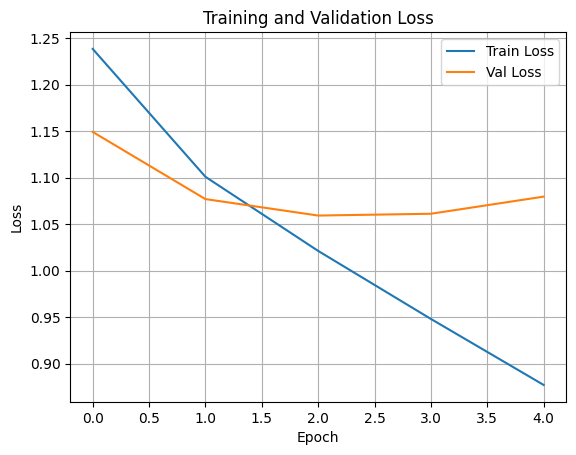

In [ ]:
# Create loaders
train_loader, val_loader = create_dataloaders(train_df, val_df, tokenizer)

# Initialize model
model = MultiTaskIndicBERT(base_model)

# Train
train_model(model, train_loader, val_loader)

In [ ]:
from sklearn.metrics import f1_score

def evaluate_model(model, data_loader, device='cuda'):
    model.eval()
    y_true_1 = []
    y_pred_1 = []

    y_true_3 = []
    y_pred_3 = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            label_1 = batch['label_1'].to(device)
            label_3 = batch['label_3'].to(device)

            out_1, out_3 = model(input_ids, attention_mask)

            # Convert probs to binary predictions
            pred_1 = (out_1 > 0.5).int().cpu().numpy()
            pred_3 = (out_3 > 0.5).int().cpu().numpy()

            y_true_1.extend(label_1.cpu().numpy())
            y_pred_1.extend(pred_1)


            y_true_3.extend(label_3.cpu().numpy())
            y_pred_3.extend(pred_3)

    # Compute F1
    # print(y_pred_1)
    # print(y_pred_3)
    f1_1 = f1_score(y_true_1, y_pred_1, average='macro')
    f1_3 = f1_score(y_true_3, y_pred_3, average='macro')

    print(f"Macro F1-score for Label 1 (gendered abuse): {f1_1:.4f}")
    print(f"Macro F1-score for Label 3 (explicit content): {f1_3:.4f}")
    return f1_1, f1_3


In [ ]:
evaluate_model(model, val_loader, device='cuda')

Macro F1-score for Label 1 (gendered abuse): 0.7129
Macro F1-score for Label 3 (explicit content): 0.7007


(0.7128878057576358, 0.7007079110771559)

In [ ]:
test_loader = create_test_loader(df_test,tokenizer)
evaluate_model(model, test_loader, device='cuda')


Macro F1-score for Label 1 (gendered abuse): 0.7092
Macro F1-score for Label 3 (explicit content): 0.7360


(0.709203878169705, 0.7359627843682514)